# Boundary padding debug

In [1]:
# system
import os
import sys
import logging
from glob import glob
from typing import Dict

# others
import yaml
import numpy as np

# torch
import torch
from torch import nn
from torchvision import transforms as tforms

# credit
from credit.data import (
    Sample,
    concat_and_reshape,
    reshape_only,
    ERA5_and_Forcing_Dataset,
    get_forward_data
)

from credit.transforms import (
    Normalize_ERA5_and_Forcing,
    ToTensor_ERA5_and_Forcing,
    load_transforms
)

from credit.parser import (
    CREDIT_main_parser,
    training_data_check
)

In [2]:
# plot
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from credit.boundary_padding import TensorPadding

In [4]:
# Logging setup
logger = logging.getLogger(__name__)

# single node steup
rank = 0
world_size = 1

## Load yaml

In [5]:
# old rollout config
# config_name = '/glade/work/ksha/CREDIT_runs/wxformer_6h/model_single.yml'
config_name = '/glade/work/ksha/CREDIT_runs/fuxi_physics/model_single.yml'
# Read YAML file
with open(config_name, 'r') as stream:
    conf = yaml.safe_load(stream)

In [6]:
conf = CREDIT_main_parser(conf)

## Data workflow

### Gather data information

In [7]:
# pick a year
train_years_range = [2018, 2020]
valid_years_range = [2018, 2020]

In [8]:
all_ERA_files = sorted(glob(conf["data"]["save_loc"]))

# check and glob surface files
if ('surface_variables' in conf['data']) and (len(conf['data']['surface_variables']) > 0):
    surface_files = sorted(glob(conf["data"]["save_loc_surface"]))

else:
    surface_files = None

# check and glob dyn forcing files
if ('dynamic_forcing_variables' in conf['data']) and (len(conf['data']['dynamic_forcing_variables']) > 0):
    dyn_forcing_files = sorted(glob(conf["data"]["save_loc_dynamic_forcing"]))

else:
    dyn_forcing_files = None

# check and glob diagnostic files
if ('diagnostic_variables' in conf['data']) and (len(conf['data']['diagnostic_variables']) > 0):
    diagnostic_files = sorted(glob(conf["data"]["save_loc_diagnostic"]))

else:
    diagnostic_files = None

# convert year info to str for file name search
train_years = [str(year) for year in range(train_years_range[0], train_years_range[1])]
valid_years = [str(year) for year in range(valid_years_range[0], valid_years_range[1])]

# Filter the files for training / validation
train_files = [file for file in all_ERA_files if any(year in file for year in train_years)]
valid_files = [file for file in all_ERA_files if any(year in file for year in valid_years)]

if surface_files is not None:

    train_surface_files = [file for file in surface_files if any(year in file for year in train_years)]
    valid_surface_files = [file for file in surface_files if any(year in file for year in valid_years)]
    
else:
    train_surface_files = None
    valid_surface_files = None

if dyn_forcing_files is not None:

    train_dyn_forcing_files = [file for file in dyn_forcing_files if any(year in file for year in train_years)]
    valid_dyn_forcing_files = [file for file in dyn_forcing_files if any(year in file for year in valid_years)]

else:
    train_dyn_forcing_files = None
    valid_dyn_forcing_files = None

if diagnostic_files is not None:

    train_diagnostic_files = [file for file in diagnostic_files if any(year in file for year in train_years)]
    valid_diagnostic_files = [file for file in diagnostic_files if any(year in file for year in valid_years)]

else:
    train_diagnostic_files = None
    valid_diagnostic_files = None

# --------------------------------------------------- #
is_train = False
# separate training set and validation set cases
if is_train:
    history_len = conf["data"]["history_len"]
    forecast_len = conf["data"]["forecast_len"]
    name = "training"
else:
    history_len = conf["data"]["valid_history_len"]
    forecast_len = conf["data"]["valid_forecast_len"]
    name = 'validation'

### Dataset

In [9]:
# # transforms
transforms = load_transforms(conf)

if conf['data']['sst_forcing']['activate']:
    sst_forcing = {'varname_skt': conf['data']['sst_forcing']['varname_skt'], 
                   'varname_ocean_mask': conf['data']['sst_forcing']['varname_ocean_mask']}
else:
    sst_forcing = None

# Z-score
dataset = ERA5_and_Forcing_Dataset(
    varname_upper_air=conf['data']['variables'],
    varname_surface=conf['data']['surface_variables'],
    varname_dyn_forcing=conf['data']['dynamic_forcing_variables'],
    varname_forcing=conf['data']['forcing_variables'],
    varname_static=conf['data']['static_variables'],
    varname_diagnostic=conf['data']['diagnostic_variables'],
    filenames=train_files,
    filename_surface=train_surface_files,
    filename_dyn_forcing=train_dyn_forcing_files,
    filename_forcing=conf['data']['save_loc_forcing'],
    filename_static=conf['data']['save_loc_static'],
    filename_diagnostic=train_diagnostic_files,
    history_len=history_len,
    forecast_len=forecast_len,
    skip_periods=conf["data"]["skip_periods"],
    one_shot=conf['data']['one_shot'],
    max_forecast_len=conf["data"]["max_forecast_len"],
    transform=transforms,
    sst_forcing=sst_forcing
)

# # sampler
# sampler = DistributedSampler(
#     dataset,
#     num_replicas=world_size,
#     rank=rank,
#     seed=seed,
#     shuffle=is_train,
#     drop_last=True
# )

### An example training batch

In [10]:
batch_single = dataset.__getitem__(999)

In [11]:
batch = {}
keys = list(batch_single.keys())
keys = keys[:-1]
for var in keys:
    batch[var] = batch_single[var].unsqueeze(0) # give a single sample batch dimension

# ------------------------- #
# base trainer workflow

if "x_surf" in batch:
    # combine x and x_surf
    # input: (batch_num, time, var, level, lat, lon), (batch_num, time, var, lat, lon)
    # output: (batch_num, var, time, lat, lon), 'x' first and then 'x_surf'
    x = concat_and_reshape(batch["x"], batch["x_surf"])
else:
    # no x_surf
    x = reshape_only(batch["x"]).to(self.device).float()

# --------------------------------------------------------------------------------- #
# add forcing and static variables
if 'x_forcing_static' in batch:

    # (batch_num, time, var, lat, lon) --> (batch_num, var, time, lat, lon)
    x_forcing_batch = batch['x_forcing_static'].permute(0, 2, 1, 3, 4)

    # concat on var dimension
    x = torch.cat((x, x_forcing_batch), dim=1)

# --------------------------------------------------------------------------------- #
# combine y and y_surf
if "y_surf" in batch:
    y = concat_and_reshape(batch["y"], batch["y_surf"])
else:
    y = reshape_only(batch["y"])

if 'y_diag' in batch:

    # (batch_num, time, var, lat, lon) --> (batch_num, var, time, lat, lon)
    y_diag_batch = batch['y_diag'].permute(0, 2, 1, 3, 4).float()

    # concat on var dimension
    y = torch.cat((y, y_diag_batch), dim=1)

In [12]:
y.max()

tensor(8.9008)

In [13]:
y_original = y.clone()
x_original = x.clone()

## Old padding

In [14]:
import torch.nn.functional as F

In [26]:
x = x_original
x_before = x.clone()

padding_opt = TensorPadding(conf['model']['padding_conf'])

x_after = padding_opt.pad(x)
x_recover = padding_opt.unpad(x_after)

In [27]:
x_after_np = np.array(x_after)
x_recover_np = np.array(x_recover)
x_bvefore_np = np.array(x_before)

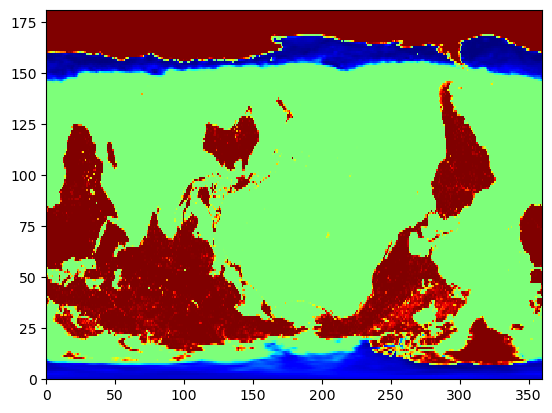

In [28]:
plt.pcolormesh(x_recover_np[0, -1, 0, ...], cmap=plt.cm.jet)

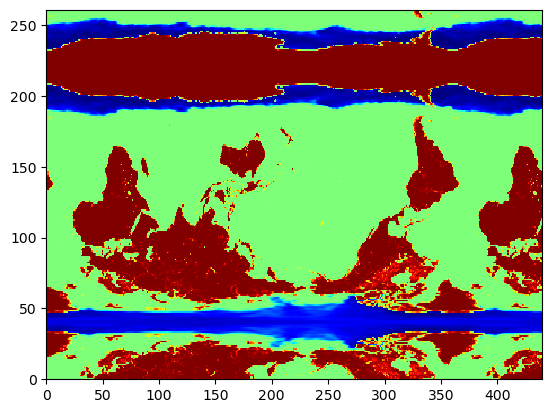

In [29]:
plt.pcolormesh(x_after_np[0, -1, 0, ...], cmap=plt.cm.jet)

In [31]:
conf['model']['padding_conf']['mode'] = 'earth'

In [32]:
x = x_original
x_before = x.clone()

padding_opt = TensorPadding(conf['model']['padding_conf'])

x_after = padding_opt.pad(x)
x_recover = padding_opt.unpad(x_after)

In [33]:
x_after_np = np.array(x_after)
x_recover_np = np.array(x_recover)
x_bvefore_np = np.array(x_before)

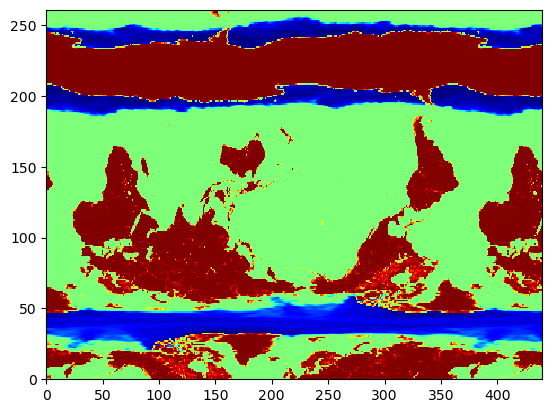

In [34]:
plt.pcolormesh(x_after_np[0, -1, 0, ...], cmap=plt.cm.jet)

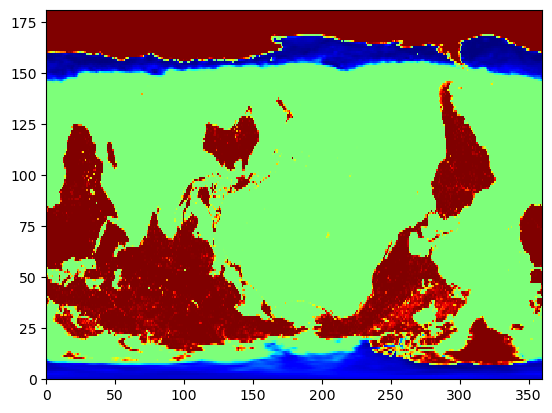

In [35]:
plt.pcolormesh(x_recover_np[0, -1, 0, ...], cmap=plt.cm.jet)

## Padding checks

In [26]:
import torch.nn.functional as F

In [23]:
x.shape

torch.Size([1, 191, 2, 181, 360])

In [174]:
pad_NS = [40, 40]
pad_WE = [40, 40]

In [179]:
x = x_original
x_before = x.clone()
x_after = earth_unpad(earth_padding(x, pad_NS, pad_WE), pad_NS, pad_WE)

x_after_np = np.array(x_after)
x_bvefore_np = np.array(x_before)

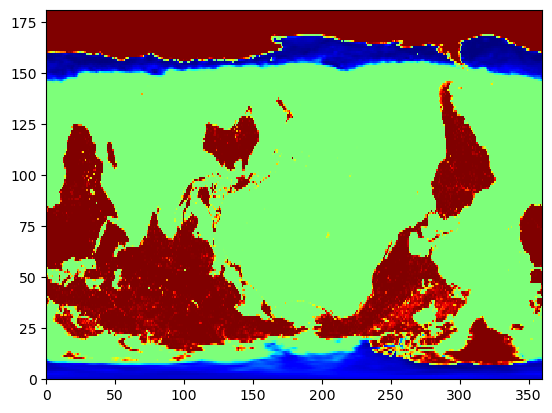

In [180]:
plt.pcolormesh(x_bvefore_np[0, -1, 0, ...], cmap=plt.cm.jet)

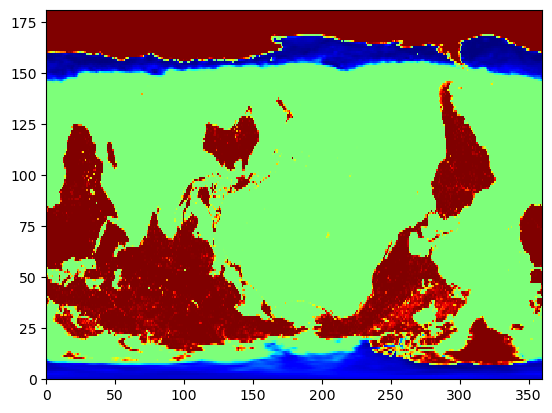

In [181]:
plt.pcolormesh(x_after_np[0, -1, 0, ...], cmap=plt.cm.jet)